In [24]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [2]:
import pandas as pd
import os
import kagglehub
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import ast
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset
from torchvision import models
import torch.nn as nn
import time
from tqdm import tqdm
# from monai.transforms import Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, ToTensor
# from monai.networks.nets import EfficientNetBN
# from monai.metrics import ROCAUCMetric
# from monai.losses import DiceCELoss
from torch.nn import BCEWithLogitsLoss
import cv2
from torch.optim import Adam

# Importation des données

In [3]:
# === 1. Préparation des données ===
df = pd.read_csv("/kaggle/input/rayon-x-label/DB_patients_norm_bbox.csv")
# df = df.drop(df.columns[0:13], axis=1).copy()
# df = df.drop(df.columns[1:-1], axis=1).copy()
# df = df.iloc[4000:, :]
# df["label"] = df["Atelectasis"]

In [4]:
def filtrer_df_maladie_unique(df, col_cible, cols_zero):
    """
    Retourne les lignes du DataFrame où :
    - col_cible == 1
    - toutes les colonnes de cols_zero == 0
    """
    condition_1 = df[col_cible] == 1
    condition_0 = df[cols_zero].sum(axis=1) == 0
    return df[condition_1 & condition_0]

maladies_exclues = [
    'Infiltration', 'Cardiomegaly', 'Effusion',  'Mass',
    'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema',
    'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'
]
atelec = filtrer_df_maladie_unique(df, "Atelectasis", maladies_exclues)
atelec = atelec[atelec["View Position"] == "PA"]

# maladies_exclues.append('Atelectasis')
no_finding = filtrer_df_maladie_unique(df, 'No Finding', maladies_exclues)
no_finding = no_finding[no_finding["View Position"] == "PA"]
no_finding = no_finding.sample(n=min(len(no_finding), len(atelec)), random_state=42)
no_finding.shape

df_final = pd.concat([atelec, no_finding])
df_final["Finding Labels"].value_counts()

Finding Labels
Atelectasis    2210
No Finding     2210
Name: count, dtype: int64

# Création du dataset

In [8]:
# 1. Dataset PyTorch multi-label
class ChestXrayMultilabelDataset(Dataset):
    def __init__(self, dataframe, label_cols, transform=None):
        self.df = dataframe
        self.label_cols = label_cols
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform    

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['Image Path']).convert('RGB')
        nom_image = row['Image Path']
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(row[self.label_cols].astype(np.float32).values, dtype=torch.float32)
        # print(nom_image)
        return image, labels

    def __afficher_image__(self, idx):
        """
        Affiche l'image (dénormalisée) et ses labels associés.
        """
        image, label = self[idx]

        # # Dénormalisation
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean  # Inverser la normalisation

        # Passage à la forme (H, W, C) pour matplotlib
        image = image.permute(1, 2, 0).clamp(0, 1)

        # Affichage
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

        # Affichage des maladies détectées
        nb_maladie = 0
        for i in range(len(label)):
            if label[i] == 1:
                print("Maladies présentes :")
                print(f" - {self.label_cols[i]}")
                nb_maladie += 1
        if(nb_maladie == 0):
            print("Aucune maladie")

In [9]:
class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        # Convert PIL to grayscale numpy
        img_np = np.array(img.convert('L'))  # convert to grayscale
        img_clahe = self.clahe.apply(img_np)

        # Reconvert to PIL with 3 channels (fake RGB)
        img_rgb = Image.fromarray(cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2RGB))
        return img_rgb

def detect_lung_roi(image_pil):
    img_gray = np.array(image_pil.convert('L'))  # PIL → grayscale numpy
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    _, thresh = cv2.threshold(img_blur, 30, 255, cv2.THRESH_BINARY)

    # Trouver les contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image_pil  # fallback

    # Récupérer le plus grand contour
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)

    # Crop l'image selon le ROI détecté
    img_cropped = img_gray[y:y+h, x:x+w]
    img_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(img_rgb)

class LungROICrop:
    def __call__(self, img):
        return detect_lung_roi(img)

class CenterCropZoom:
    def __init__(self, zoom_factor=1.2):
        self.zoom_factor = zoom_factor

    def __call__(self, img):
        w, h = img.size
        new_w = int(w / self.zoom_factor)
        new_h = int(h / self.zoom_factor)
        left = (w - new_w) // 2
        top = (h - new_h) // 2
        right = left + new_w
        bottom = top + new_h
        img_cropped = img.crop((left, top, right, bottom))
        return img_cropped

## Transformations

In [10]:
transform = transforms.Compose([
    LungROICrop(),
    transforms.Resize((256, 256)),  # Agrandit
    CenterCropZoom(zoom_factor=1.2),  # Zoom centré
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

## Division du dataset

In [11]:
# 2. Préparation des données
label_columns = ['Atelectasis']

train_df, val_df = train_test_split(df_final, test_size=0.2, random_state=42)


train_dataset = ChestXrayMultilabelDataset(train_df, label_columns, transform)
val_dataset = ChestXrayMultilabelDataset(val_df, label_columns, transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Modele

In [12]:
model = models.densenet121(pretrained=True)

# Remplacer la dernière couche (classifier)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 1)  # Pour classification binaire


# === 2. Détection d'accélérateur (GPU si dispo) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# === 3. Définir la loss & l’optimiseur ===
criterion = nn.BCEWithLogitsLoss()  # Car on utilise une sortie unique + sigmoid implicite
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

pos_weight = torch.tensor([7000 / 2000]).to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 179MB/s]


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
import time
from tqdm import tqdm

# === Initialisation ===
n_epochs = 10
best_val_f1 = 0.0
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    print(f"\n===== Epoch {epoch+1}/{n_epochs} =====")
    start_time = time.time()

    # --- Mode entraînement ---
    model.train()
    train_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device).view(-1, 1)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs).cpu().detach().numpy() > 0.5
        y_pred_train.extend(preds.astype(int).flatten())
        y_true_train.extend(labels.cpu().numpy().astype(int).flatten())

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Mode validation ---
    model.eval()
    val_loss = 0.0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device).view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            preds = torch.sigmoid(outputs).cpu().numpy() > 0.5
            y_pred_val.extend(preds.astype(int).flatten())
            y_true_val.extend(labels.cpu().numpy().astype(int).flatten())

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # === Metrics ===
    train_acc = accuracy_score(y_true_train, y_pred_train)
    train_prec = precision_score(y_true_train, y_pred_train, zero_division=0)
    train_rec = recall_score(y_true_train, y_pred_train, zero_division=0)
    train_f1 = f1_score(y_true_train, y_pred_train, zero_division=0)

    val_acc = accuracy_score(y_true_val, y_pred_val)
    val_prec = precision_score(y_true_val, y_pred_val, zero_division=0)
    val_rec = recall_score(y_true_val, y_pred_val, zero_division=0)
    val_f1 = f1_score(y_true_val, y_pred_val, zero_division=0)

    epoch_time = time.time() - start_time

    print(f"⏱️ Temps: {epoch_time:.2f}s")
    print(f"📉 Loss: Train={avg_train_loss:.4f} | Val={avg_val_loss:.4f}")
    print(f"✅ Accuracy: Train={train_acc:.4f} | Val={val_acc:.4f}")
    print(f"🎯 Precision: Train={train_prec:.4f} | Val={val_prec:.4f}")
    print(f"📢 Recall (Sensivity): Train={train_rec:.4f} | Val={val_rec:.4f}")
    print(f"🏆 F1-Score: Train={train_f1:.4f} | Val={val_f1:.4f}")

    # === Sauvegarde du meilleur modèle ===
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Meilleur modèle sauvegardé.")



===== Epoch 1/10 =====


⏱️ Temps: 189.19s
📉 Loss: Train=1.0849 | Val=0.9970
✅ Accuracy: Train=0.6239 | Val=0.6109
🎯 Precision: Train=0.5798 | Val=0.5733
📢 Recall (Sensivity): Train=0.8815 | Val=0.9471
🏆 F1-Score: Train=0.6995 | Val=0.7143
💾 Meilleur modèle sauvegardé.

===== Epoch 2/10 =====


⏱️ Temps: 143.11s
📉 Loss: Train=0.9374 | Val=1.0106
✅ Accuracy: Train=0.6555 | Val=0.7014
🎯 Precision: Train=0.5967 | Val=0.6503
📢 Recall (Sensivity): Train=0.9453 | Val=0.9053
🏆 F1-Score: Train=0.7316 | Val=0.7569
💾 Meilleur modèle sauvegardé.

===== Epoch 3/10 =====


⏱️ Temps: 144.44s
📉 Loss: Train=0.8790 | Val=0.9802
✅ Accuracy: Train=0.6892 | Val=0.6663
🎯 Precision: Train=0.6223 | Val=0.6171
📢 Recall (Sensivity): Train=0.9516 | Val=0.9229
🏆 F1-Score: Train=0.7525 | Val=0.7396

===== Epoch 4/10 =====


⏱️ Temps: 142.13s
📉 Loss: Train=0.8093 | Val=1.0107
✅ Accuracy: Train=0.7132 | Val=0.6437
🎯 Precision: Train=0.6435 | Val=0.5967
📢 Recall (Sensivity): Train=0.9476 | Val=0.9449
🏆 F1-Score: Train=0.7665 | Val=0.7315

===== Epoch 5/10 =====


⏱️ Temps: 141.65s
📉 Loss: Train=0.7296 | Val=1.0557
✅ Accuracy: Train=0.7421 | Val=0.6923
🎯 Precision: Train=0.6677 | Val=0.6431
📢 Recall (Sensivity): Train=0.9567 | Val=0.9009
🏆 F1-Score: Train=0.7865 | Val=0.7505

===== Epoch 6/10 =====


⏱️ Temps: 141.88s
📉 Loss: Train=0.6811 | Val=1.0616
✅ Accuracy: Train=0.7783 | Val=0.6640
🎯 Precision: Train=0.7042 | Val=0.6156
📢 Recall (Sensivity): Train=0.9544 | Val=0.9207
🏆 F1-Score: Train=0.8104 | Val=0.7379

===== Epoch 7/10 =====


⏱️ Temps: 142.68s
📉 Loss: Train=0.6216 | Val=1.2347
✅ Accuracy: Train=0.7879 | Val=0.7036
🎯 Precision: Train=0.7150 | Val=0.6758
📢 Recall (Sensivity): Train=0.9527 | Val=0.8128
🏆 F1-Score: Train=0.8169 | Val=0.7380

===== Epoch 8/10 =====


⏱️ Temps: 142.27s
📉 Loss: Train=0.5311 | Val=1.3751
✅ Accuracy: Train=0.8278 | Val=0.6629
🎯 Precision: Train=0.7564 | Val=0.6423
📢 Recall (Sensivity): Train=0.9636 | Val=0.7753
🏆 F1-Score: Train=0.8475 | Val=0.7026

===== Epoch 9/10 =====


⏱️ Temps: 142.41s
📉 Loss: Train=0.4680 | Val=1.2640
✅ Accuracy: Train=0.8552 | Val=0.6629
🎯 Precision: Train=0.7898 | Val=0.6266
📢 Recall (Sensivity): Train=0.9653 | Val=0.8502
🏆 F1-Score: Train=0.8688 | Val=0.7215

===== Epoch 10/10 =====


⏱️ Temps: 142.77s
📉 Loss: Train=0.4478 | Val=1.5805
✅ Accuracy: Train=0.8682 | Val=0.6878
🎯 Precision: Train=0.8077 | Val=0.6673
📢 Recall (Sensivity): Train=0.9641 | Val=0.7819
🏆 F1-Score: Train=0.8790 | Val=0.7201


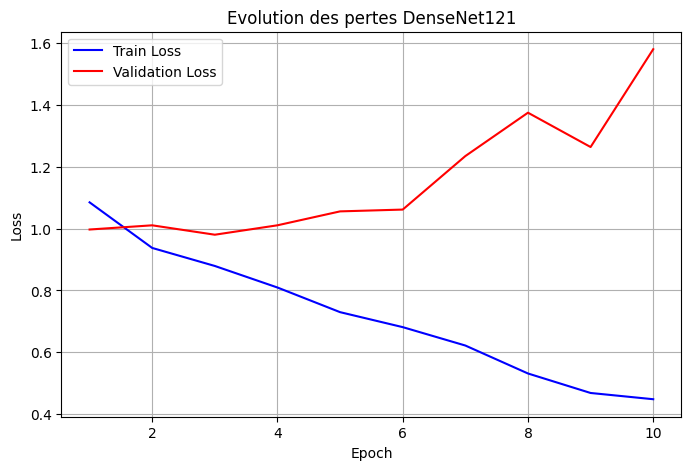

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, 11)  # 10 epochs

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution des pertes DenseNet121')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Chemin vers ton image de test
n1 = 0
n0 = 0
b1 = 0
b0 = 0
for i in range(len(val_df_no_finding)):
    image_path = val_df_no_finding.iloc[i,1]  # modifie ici

    # Ouvrir et transformer l'image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image)  # appliquer les transformations
    input_tensor = input_tensor.unsqueeze(0)  # ajouter une dimension batch (1, C, H, W)
    
    input_tensor = input_tensor.to(device)  # device défini avant (cuda ou cpu)
    model.eval()  # mode évaluation
    
    with torch.no_grad():
        output = model(input_tensor)  # sortie brute (logits)
        prob = torch.sigmoid(output)  # passer la sortie par sigmoid pour avoir une probabilité entre 0 et 1
        pred = (prob > 0.5).float()   # seuil à 0.5 pour décision binaire

    
    if(pred >= 0.5):
        n1 += 1
        if( val_df_no_finding.iloc[i,0] == 1):
            b1 += 1
        # print(i, image_path, val_df_no_finding.iloc[i,0])
        # print(f"Probabilité d'atelectasis : {prob.item():.4f}")
        # print(f"Prédiction (1 = présence, 0 = absence) : {int(pred.item())}")

    if(pred < 0.5):
        n0 += 1
        if( val_df_no_finding.iloc[i,0] == 0):
            b0 += 1

415 991 0 991
